In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import scipy
import numpy as np
from numba import njit
from tqdm import tqdm
from matplotlib import pyplot as plt

from modules import c, first_order_rk4, first_order_rk4_slow

## TOV equation:  (diff-eq approach)
\begin{gather}
    \frac{dP}{dr} = 
    -\frac{G m}{r^2} \rho 
    \left(1 + \frac{P}{\rho c^2}\right) 
    \left(1 + \frac{4 \pi r^3 P}{m c^2}\right)
    \left(1 - \frac{2 G m}{r c^2}\right)^{-1}
\end{gather}

but we want to solve the scaled TOV equations:
\begin{gather}
    \boxed{
    \frac{dp(x)}{dx} = -\frac{1}{2} \frac{\left[\epsilon(x) + p(x))\right]\left[m(x) + 3 x^3 p(x)\right]}{x^2 \left[1 - m(x)/x\right]}
    \\
    \frac{dm(x)}{dx} = 3 x^2 \epsilon(x)
    }
\end{gather}

In [3]:
Epsilon_naught = 1.285  # GeV / fm^3

def epsilon(p_of_x, m_of_x):
    # eps_of_p = np.sqrt((p_of_x * c) ** 2 + (m_of_x * c) ** 2)
    eps_of_p = np.sqrt((p_of_x * 1) ** 2 + (m_of_x * 1) ** 2)
    
    return eps_of_p

def m(x, p_of_x):
    return 4 * np.pi * x**2 * p_of_x

In [4]:
n = 1_000

x, dx = np.linspace(0, 100, n, retstep=True)  # units? lets use meters for now  -- just kidding it's solar masses
x[0] = 1e-9  # eps

In [ ]:
# def solve_ivp_diffeq(x, p):
#     return np.array([p[0], -0.5 * (epsilon(p[1], m(x, p[1])) + p[1]) * (m(x, p[1]) + 3 * x * p[1]) / (x**2 * (1 - m(x, p[1]) / x))])
# 
# solve_ivp_result = scipy.integrate.solve_ivp(solve_ivp_diffeq, (x[0], x[-1]), (0., 1.), t_eval=x)
# print(solve_ivp_result)
# 
# p = solve_ivp_result.y[0]
# p_pr = solve_ivp_result.y[1]
# 
# plt.plot(x, p, label="p")
# plt.plot(x, p_pr, label="p'")
# # plt.yscale("log")
# plt.legend()
# plt.show()

/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_24860/2643870645.py:5: RuntimeWarning: overflow encountered in scalar power
  eps_of_p = np.sqrt((p_of_x * 1) ** 2 + (m_of_x * 1) ** 2)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_24860/686111469.py:2: RuntimeWarning: invalid value encountered in scalar divide
  equation = -0.5 * (epsilon(p, m(x, p)) + p) * (m(x, p) + 3 * x * p) / (x**2 * (1 - m(x, p) / x))


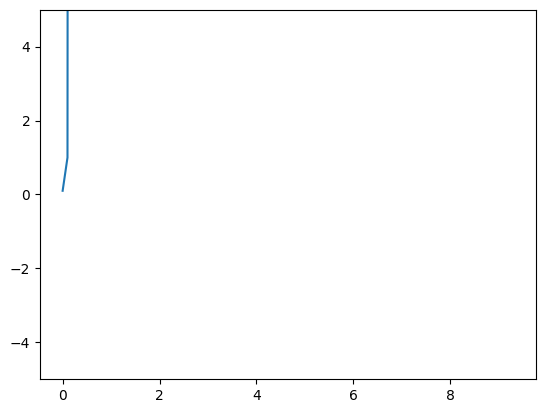

In [17]:
def ode(x, p):
    equation = -0.5 * (epsilon(p, m(x, p)) + p) * (m(x, p) + 3 * x * p) / (x**2 * (1 - m(x, p) / x))
    return equation

ode_solution = first_order_rk4_slow(x, x[1], 1, ode)

plt.plot(x, ode_solution)
plt.ylim(-5, 5)
plt.show()

## TOV equation(s): (integral-eq approach)

\begin{gather}
    \frac{dp}{dr} = -\frac{G \rho(r) \mathcal{M}(r)}{r^2}
    \\
    \frac{d\mathcal{M}}{dr} = 4 \pi^2 \rho(r)
    \\
    \mathcal{M}(r) = 4 \pi \int_0^r r'^2 \rho(r') dr'
\end{gather}